In [ ]:
# Install Kaggle package (if not installed)
!pip install kaggle

# Download dataset
!kaggle datasets download -d puneet6060/intel-image-classification

# Extract dataset
!unzip intel-image-classification.zip -d intel_images


Streaming output truncated to the last 5000 lines.
  inflating: intel_images/seg_train/seg_train/mountain/7506.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7537.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7539.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7551.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7560.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7565.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7578.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7581.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7586.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7647.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7652.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7654.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/7662.jpg  
  inflating: intel_images/seg_train/seg_train/mountain/767.jpg  
  inflating: intel_images/

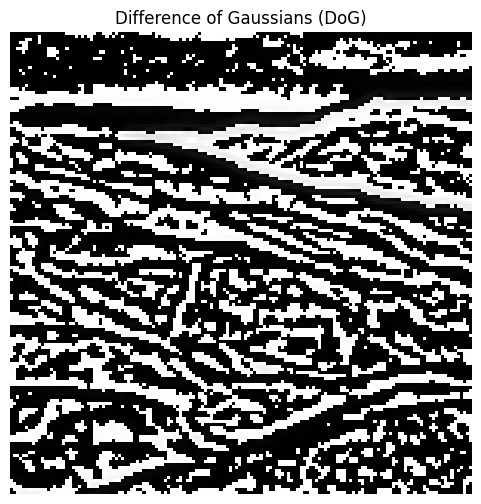

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

dataset_path = "intel_images/seg_train/seg_train/"

def compute_dog(image_path, sigma=1.0, k=1.6):
    """Compute Difference of Gaussians (DoG) for a given image."""

    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply Gaussian Blur with different sigmas
    blur1 = cv2.GaussianBlur(img, (0, 0), sigma)
    blur2 = cv2.GaussianBlur(img, (0, 0), sigma * k)

    # Compute DoG
    dog = blur1 - blur2

    return dog

# Load sample image from "forest" category
category = "glacier"  # Change this to any category in dataset
image_list = os.listdir(os.path.join(dataset_path, category))
sample_image_path = os.path.join(dataset_path, category, image_list[0])

dog_image = compute_dog(sample_image_path)

# Display the DoG image
plt.figure(figsize=(6, 6))
plt.imshow(dog_image, cmap="gray")
plt.title("Difference of Gaussians (DoG)")
plt.axis("off")
plt.show()


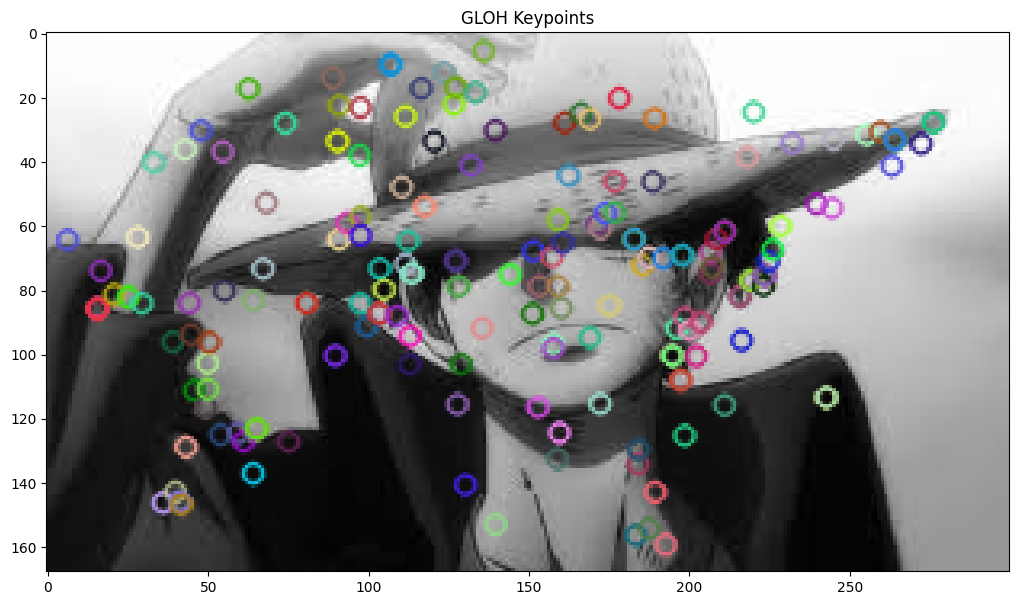

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def compute_sift_keypoints(image):
    """Compute SIFT keypoints and descriptors"""
    sift = cv2.SIFT_create()
    return sift.detectAndCompute(image, None)

def log_polar_histogram(descriptors, bins=8):
    """Convert SIFT descriptors into GLOH-style log-polar histograms"""


    num_keypoints, descriptor_length = descriptors.shape

    sift_desc = descriptors.reshape(num_keypoints, 16, bins)
    gl_desc = np.zeros((num_keypoints, 136))

    for i in range(num_keypoints):
        for j in range(8):
            gl_desc[i, j*17:(j+1)*17] = np.histogram(np.log1p(sift_desc[i, :, j]), bins=17, range=(0, np.log(16)+1))[0]

    return gl_desc

def apply_pca(gloh_descriptors, output_dim=128):
    """Reduce GLOH descriptor dimension using PCA"""
    if gloh_descriptors is None or gloh_descriptors.shape[0] < output_dim:
        return gloh_descriptors

    return PCA(n_components=output_dim).fit_transform(gloh_descriptors)

# Load image
image = cv2.imread("images.jpg", cv2.IMREAD_GRAYSCALE)

# Compute SIFT keypoints
keypoints, sift_descriptors = compute_sift_keypoints(image)

if sift_descriptors is not None:
    gloh_descriptors = log_polar_histogram(sift_descriptors)
    final_gloh_desc = apply_pca(gloh_descriptors)

    # Display keypoints
    plt.imshow(cv2.drawKeypoints(image, keypoints, None), cmap="gray")
    plt.title("GLOH Keypoints")
    plt.show()
else:
    print("No keypoints detected.")


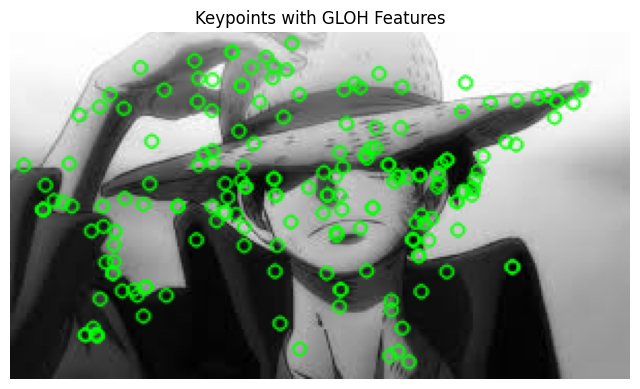

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load an image in grayscale
image = cv2.imread('images.jpg', cv2.IMREAD_GRAYSCALE)


# Compute gradient magnitude and orientation using Sobel operators
grad_x = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=3)
grad_y = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=3)
mag, angle = cv2.cartToPolar(grad_x, grad_y, angleInDegrees=True)

# Compute keypoints using SIFT
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(image, None)

# Compute GLOH features for each keypoint
gloh_features = []
for kp in keypoints:
    x, y = int(kp.pt[0]), int(kp.pt[1])
    scale = int(kp.size / 2)

    # Ensure the patch is within image bounds
    if (y - scale) >= 0 and (y + scale) < image.shape[0] and (x - scale) >= 0 and (x + scale) < image.shape[1]:
        histogram = cv2.calcHist([angle[y-scale:y+scale, x-scale:x+scale]], [0], None, [36], [0, 360])
        gloh_features.append(histogram.flatten())

# Convert to a NumPy array
if gloh_features:
    gloh_features = np.array(gloh_features)
else:
    print("No GLOH features extracted.")

# Visualize keypoints
image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0))

plt.figure(figsize=(8, 6))
plt.imshow(image_with_keypoints, cmap="gray")
plt.title("Keypoints with GLOH Features")
plt.axis("off")
plt.show()


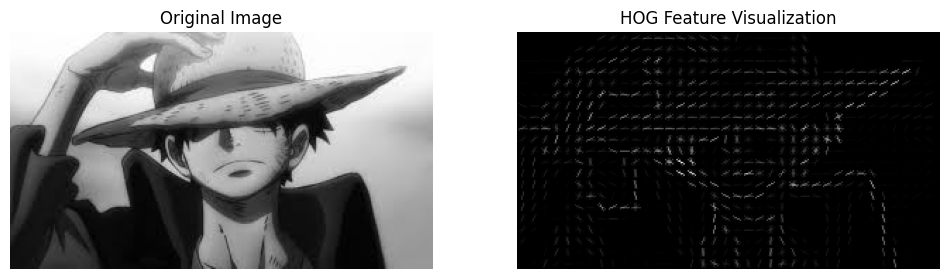

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import color

# Load the image in grayscale
image = cv2.imread('images.jpg', cv2.IMREAD_GRAYSCALE)


# Compute HOG descriptors and visualization
hog_features, hog_image = hog(image,
                              orientations=9,
                              pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2),
                              visualize=True,
                              feature_vector=True)

# Display the original and HOG feature image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Original image
ax1.imshow(image, cmap='gray')
ax1.set_title("Original Image")
ax1.axis("off")

# HOG visualization
ax2.imshow(hog_image, cmap='gray')
ax2.set_title("HOG Feature Visualization")
ax2.axis("off")

plt.show()


SIFT

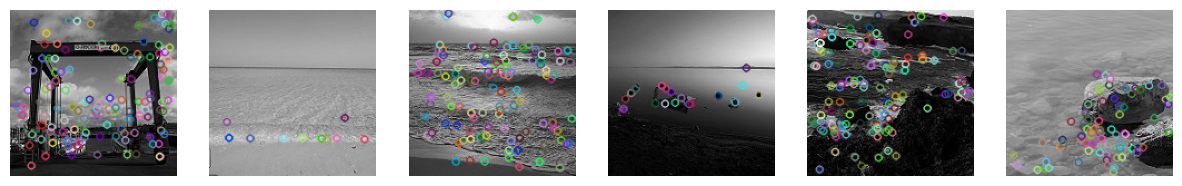

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Define dataset path
dataset_path = "intel_images/seg_train/seg_train/"

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Dictionary to store keypoints and descriptors
sift_features = {}

# Load first few images from a category
category = "sea"  # Choose a category
category_path = os.path.join(dataset_path, category)
images = sorted(os.listdir(category_path))[:6]

for img_name in images:
    img_path = os.path.join(category_path, img_name)

    # Read image in grayscale
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if image is not None:
        # Detect keypoints and descriptors
        keypoints, descriptors = sift.detectAndCompute(image, None)

        # Store features
        sift_features[img_name] = (keypoints, descriptors)

        # Draw keypoints
        output_image = cv2.drawKeypoints(image, keypoints, None,
                                         flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)



import cv2
import matplotlib.pyplot as plt
import os
import math

def show_sift(images, path, sift):
    rows = math.ceil(len(images) / 5)
    fig, axes = plt.subplots(rows, 6, figsize=(15, 3 * rows))

    for ax, img_name in zip(axes.flat, images):
        img = cv2.imread(os.path.join(path, img_name), cv2.IMREAD_GRAYSCALE)
        kp, _ = sift.detectAndCompute(img, None)
        ax.imshow(cv2.drawKeypoints(img, kp, None), cmap="gray")
        ax.axis("off")

    # Remove empty subplots
    for ax in axes.flat[len(images):]:
        fig.delaxes(ax)

    plt.show()

# Usage
show_sift(images, category_path, sift)



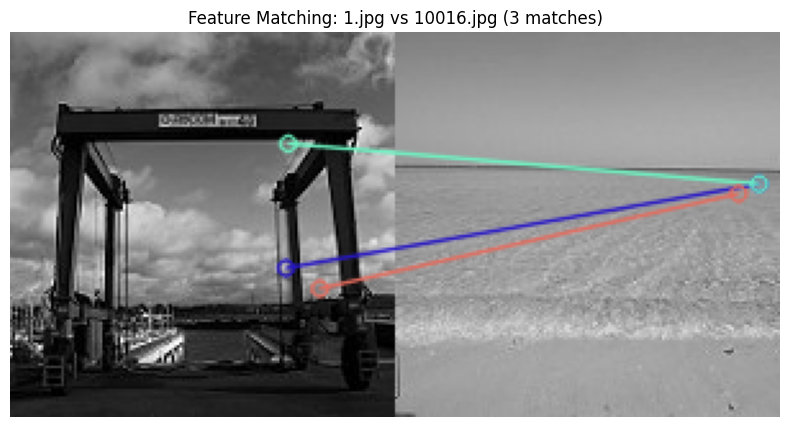

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os



def extract_sift_features(image_path):
    """Extracts SIFT features, applying CLAHE for better feature detection."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    sift = cv2.SIFT_create(contrastThreshold=0.01, edgeThreshold=10, sigma=1.6)
    kp, desc = sift.detectAndCompute(img, None)

    return img, kp, desc

def match_sift_features(image1, image2, path):
    """Matches SIFT features between two images and visualizes matches."""

    # Extract SIFT features
    img1, kp1, desc1 = extract_sift_features(os.path.join(path, image1))
    img2, kp2, desc2 = extract_sift_features(os.path.join(path, image2))


    # FLANN-based matcher
    flann = cv2.FlannBasedMatcher(dict(algorithm=3, trees=10), dict(checks=30))

    # Match descriptors with ratio test
    matches = flann.knnMatch(desc1, desc2, k=2)
    good_matches = [m for m, n in matches if m.distance < 0.78 * n.distance]  # Stricter threshold


    # Draw matches
    matched_img = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None,
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Display results
    plt.figure(figsize=(10, 5))
    plt.imshow(matched_img, cmap="gray")
    plt.title(f"Feature Matching: {image1} vs {image2} ({len(good_matches)} matches)")
    plt.axis("off")
    plt.show()

# Usage
match_sift_features(images[0], images[1], category_path)


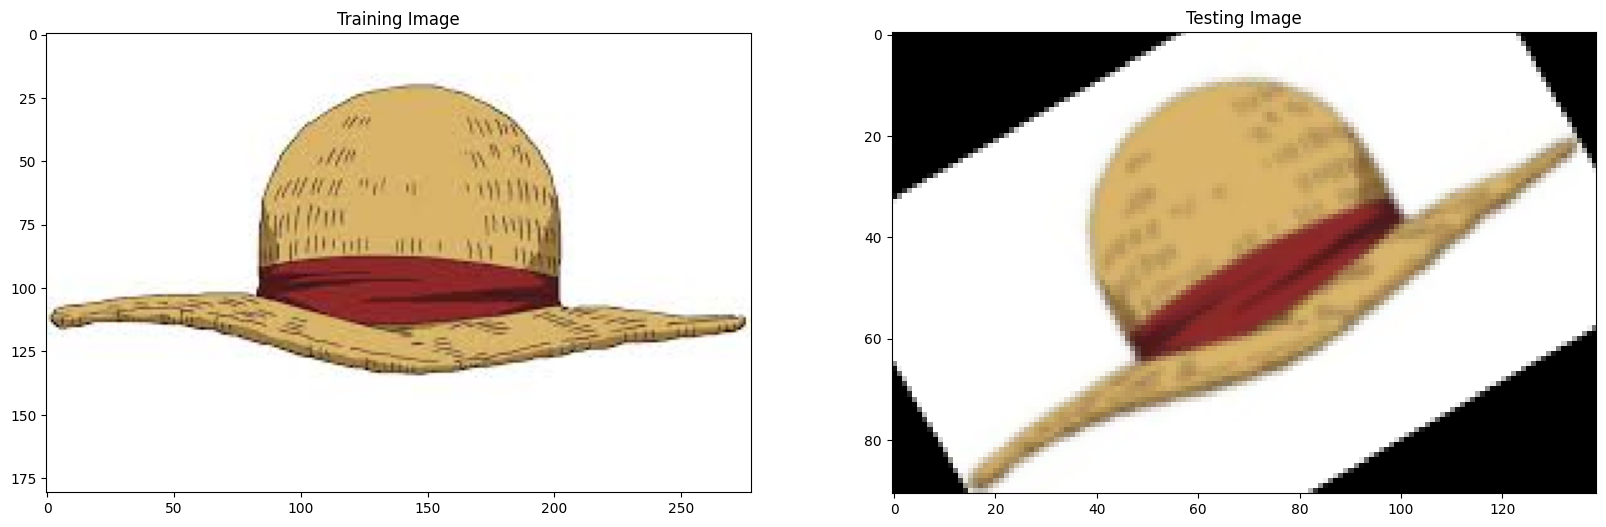

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Load the image
image1 = cv2.imread('strawhat.jpeg')
image2 = cv2.imread('images.jpg')
# Convert the training image to RGB
training_image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

# Convert the training image to gray scale
training_gray = cv2.cvtColor(training_image, cv2.COLOR_RGB2GRAY)

# Create test image by adding Scale Invariance and Rotational Invariance
test_image =  cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
test_image = cv2.pyrDown(test_image)
num_rows, num_cols = test_image.shape[:2]

rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), 30, 1)
test_image = cv2.warpAffine(test_image, rotation_matrix, (num_cols, num_rows))

test_gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)

# Display traning image and testing image
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Training Image")
plots[0].imshow(training_image)

plots[1].set_title("Testing Image")
plots[1].imshow(test_image)

Number of Keypoints Detected In The Training Image:  110
Number of Keypoints Detected In The Query Image:  59


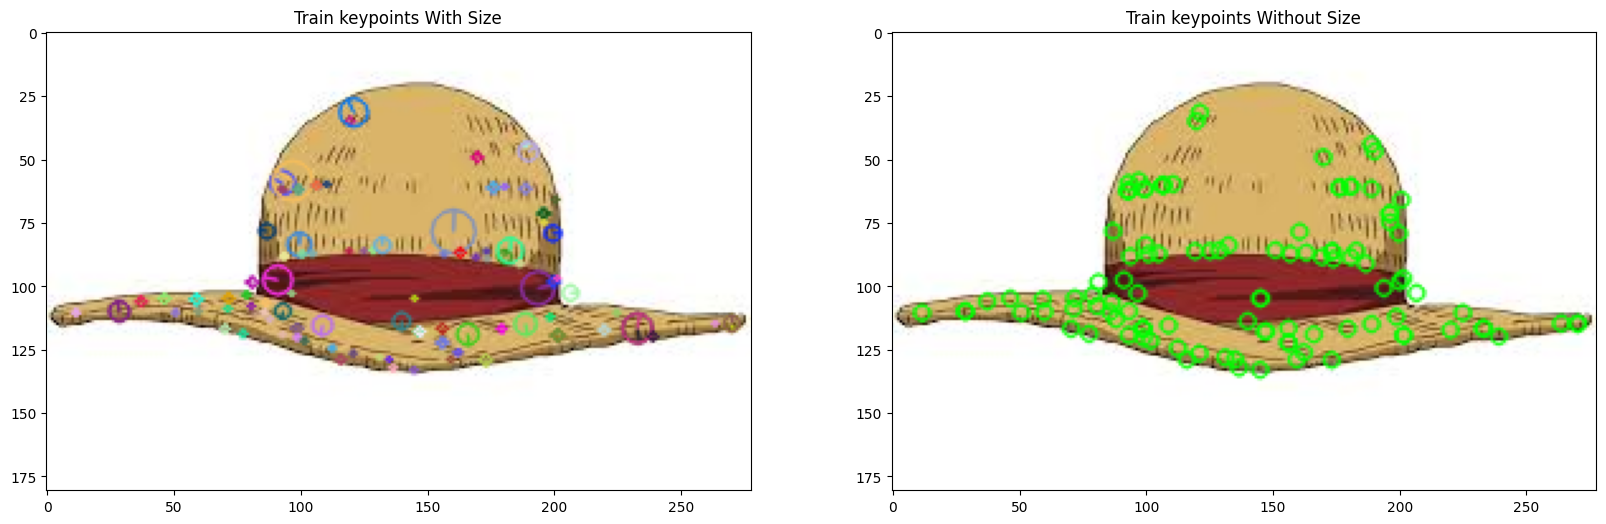

In [ ]:
sift = cv2.xfeatures2d.SIFT_create()

train_keypoints, train_descriptor = sift.detectAndCompute(training_gray, None)
test_keypoints, test_descriptor = sift.detectAndCompute(test_gray, None)

keypoints_without_size = np.copy(training_image)
keypoints_with_size = np.copy(training_image)

cv2.drawKeypoints(training_image, train_keypoints, keypoints_without_size, color = (0, 255, 0))

cv2.drawKeypoints(training_image, train_keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with and without keypoints size
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Train keypoints With Size")
plots[0].imshow(keypoints_with_size, cmap='gray')

plots[1].set_title("Train keypoints Without Size")
plots[1].imshow(keypoints_without_size, cmap='gray')

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(test_keypoints))

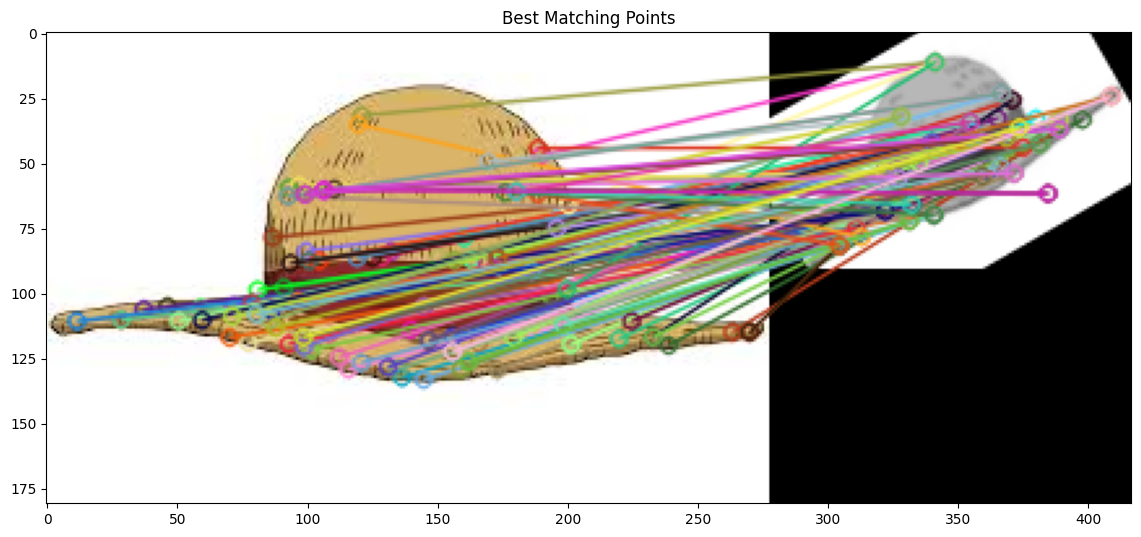


Number of Matching Keypoints Between The Training and Query Images:  110


In [ ]:
# Create a Brute Force Matcher object.
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck = False)

# Perform the matching between the SIFT descriptors of the training image and the test image
matches = bf.match(train_descriptor, test_descriptor)

# The matches with shorter distance are the ones we want.
matches = sorted(matches, key = lambda x : x.distance)

result = cv2.drawMatches(training_image, train_keypoints, test_gray, test_keypoints, matches, test_gray, flags = 2)

# Display the best matching points
plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))

SURF


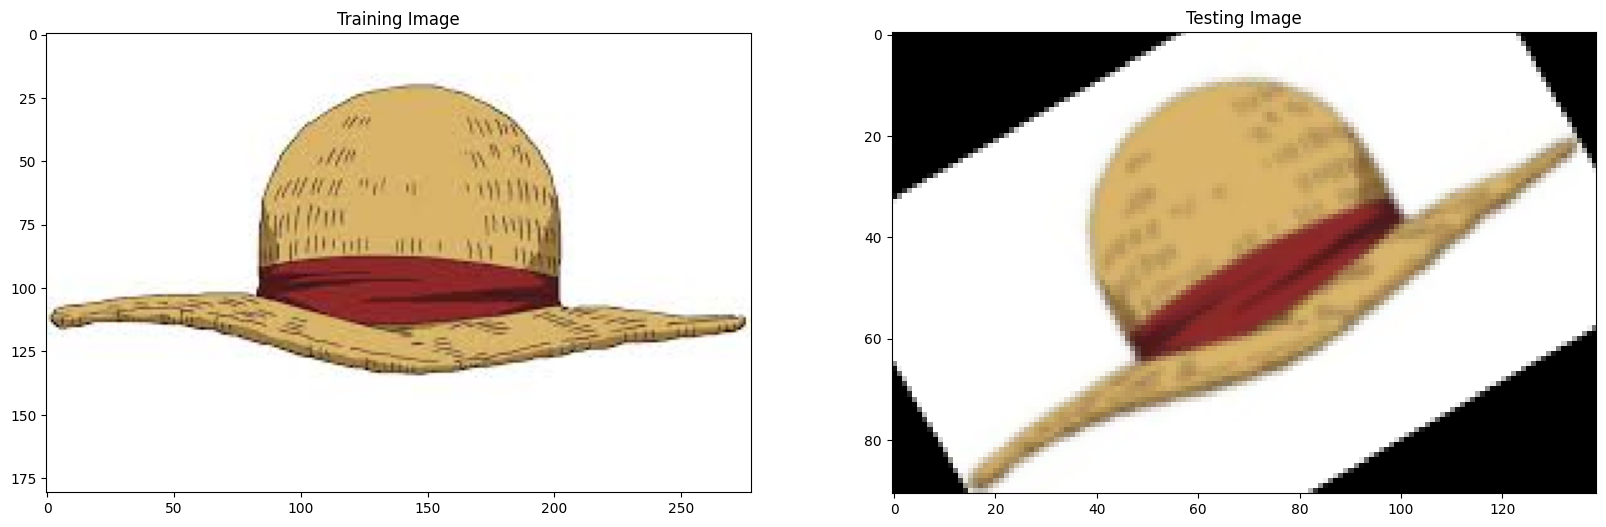

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

image1 = cv2.imread('strawhat.jpeg')
image2 = cv2.imread('images.jpg')

# Convert the training image to RGB
training_image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
training_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
# Convert the training image to gray scale
training_gray = cv2.cvtColor(training_image, cv2.COLOR_RGB2GRAY)

# Create test image by adding Scale Invariance and Rotational Invariance
test_image = cv2.pyrDown(training_image)
# test_image = cv2.pyrDown(test_image)
num_rows, num_cols = test_image.shape[:2]

rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), 30, 1)
test_image = cv2.warpAffine(test_image, rotation_matrix, (num_cols, num_rows))

test_gray = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)

# Display traning image and testing image
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Training Image")
plots[0].imshow(training_image)

plots[1].set_title("Testing Image")
plots[1].imshow(test_image)

Number of Keypoints Detected In The Training Image:  349
Number of Keypoints Detected In The Query Image:  20


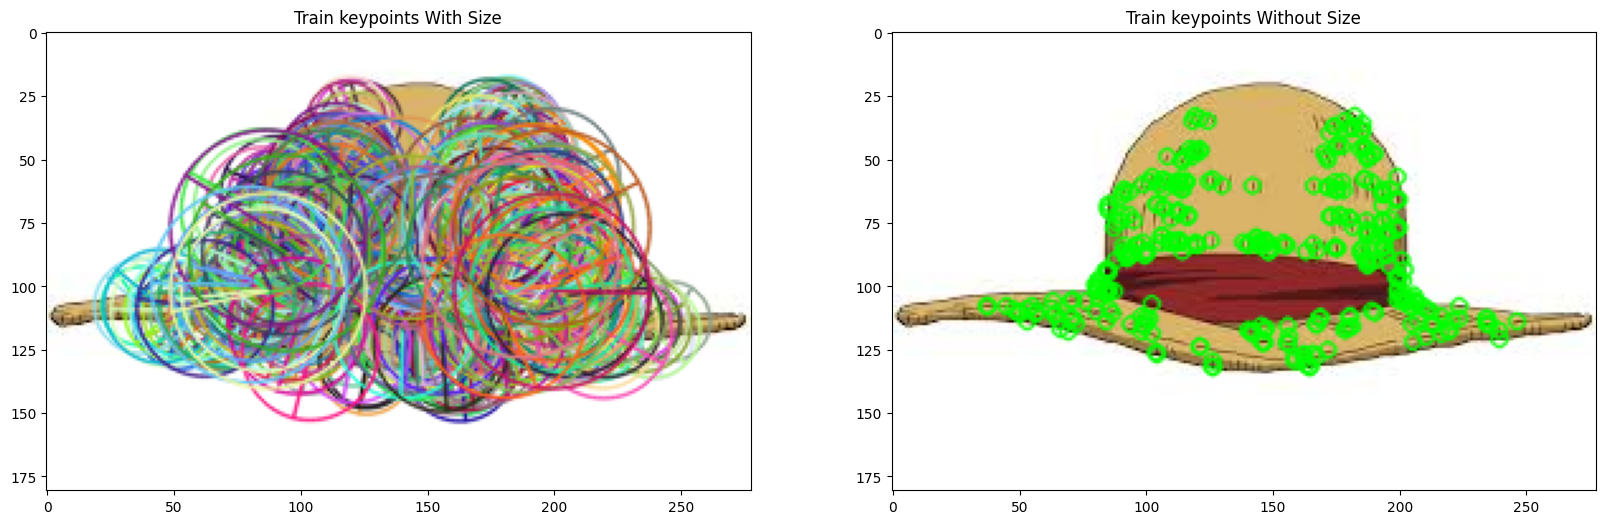

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Convert images to grayscale
training_gray = cv2.cvtColor(training_image, cv2.COLOR_BGR2GRAY)
test_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

# Use ORB instead of SURF
orb = cv2.ORB_create()

train_keypoints, train_descriptor = orb.detectAndCompute(training_gray, None)
test_keypoints, test_descriptor = orb.detectAndCompute(test_gray, None)

# Draw Keypoints
keypoints_without_size = np.copy(training_image)
keypoints_with_size = np.copy(training_image)

cv2.drawKeypoints(training_image, train_keypoints, keypoints_without_size, color=(0, 255, 0))
cv2.drawKeypoints(training_image, train_keypoints, keypoints_with_size,
                  flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display images
fx, plots = plt.subplots(1, 2, figsize=(20, 10))

plots[0].set_title("Train keypoints With Size")
plots[0].imshow(keypoints_with_size, cmap='gray')

plots[1].set_title("Train keypoints Without Size")
plots[1].imshow(keypoints_without_size, cmap='gray')

print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))
print("Number of Keypoints Detected In The Query Image: ", len(test_keypoints))


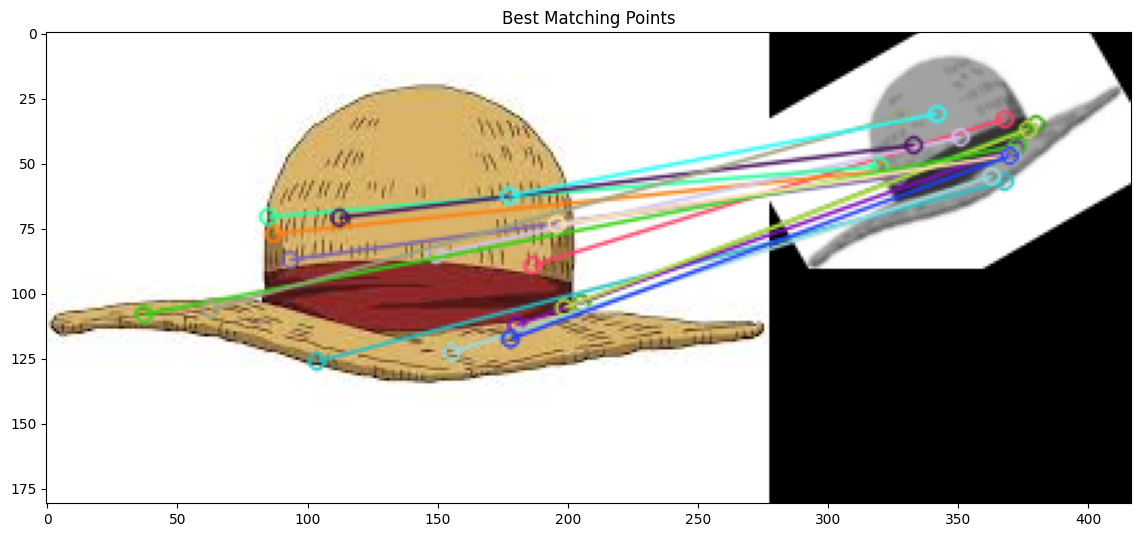


Number of Matching Keypoints Between The Training and Query Images:  16


In [ ]:
# Create a Brute Force Matcher object.
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck = True)

# Perform the matching between the SURF descriptors of the training image and the test image
matches = bf.match(train_descriptor, test_descriptor)

# The matches with shorter distance are the ones we want.
matches = sorted(matches, key = lambda x : x.distance)

result = cv2.drawMatches(training_image, train_keypoints, test_gray, test_keypoints, matches, test_gray, flags = 2)

# Display the best matching points
plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))

Using SIFT feature detector
Loading image paths...
Extracting features from images...


100%|██████████| 1000/1000 [00:13<00:00, 73.02it/s]


Building vocabulary with 200 visual words...
Computing histograms...


100%|██████████| 1000/1000 [00:12<00:00, 79.14it/s]


Training SVM classifier...
Evaluating model...
Accuracy: 0.9550

Classification Report:
              precision    recall  f1-score   support

    building       0.94      0.97      0.95        96
      forest       0.97      0.94      0.96       104

    accuracy                           0.95       200
   macro avg       0.95      0.96      0.95       200
weighted avg       0.96      0.95      0.96       200



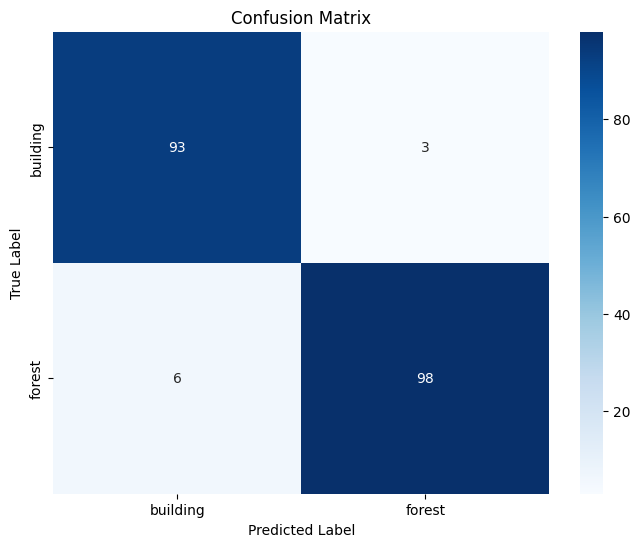

Saving model...

Example predictions:
Visualizing keypoints on sample images...


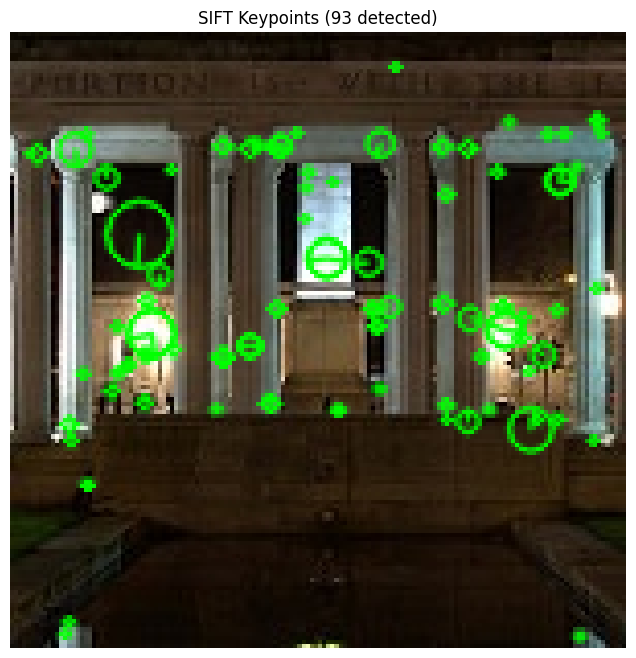

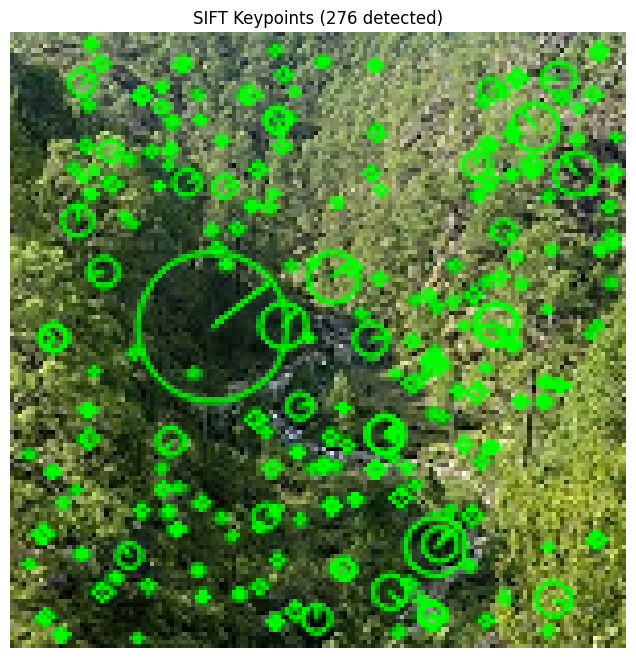

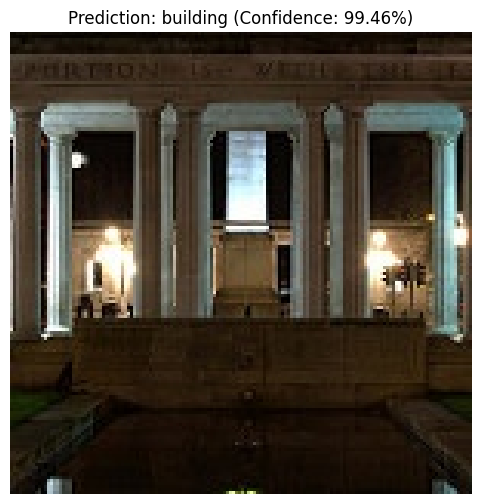

Image: 9810.jpg
Predicted class: building with 99.46% confidence



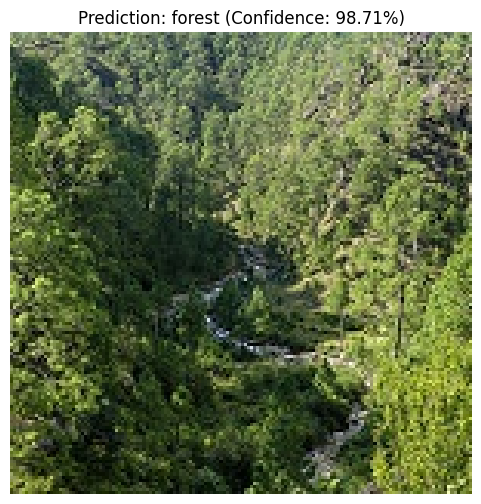

Image: 3309.jpg
Predicted class: forest with 98.71% confidence



In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import seaborn as sns
from tqdm import tqdm
import glob
import random
import pickle

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define paths - update these to match your system
BASE_PATH = "intel_images/seg_train/"
TRAIN_BUILDINGS_PATH = os.path.join(BASE_PATH, "seg_train/buildings")
TRAIN_FOREST_PATH = os.path.join(BASE_PATH, "seg_train/forest")
TEST_BUILDINGS_PATH = os.path.join(BASE_PATH, "seg_test/buildings")
TEST_FOREST_PATH = os.path.join(BASE_PATH, "seg_test/forest")

# Parameters
MAX_IMAGES_PER_CLASS = 500  # Limit number of images to process
FEATURE_DETECTOR = 'SIFT'  # Options: 'SIFT', 'SURF', 'ORB'
VOCABULARY_SIZE = 200  # Size of the bag of visual words vocabulary
SAMPLE_SIZE = (150, 150)  # Resize images to this size

# Initialize feature detector
if FEATURE_DETECTOR == 'SIFT':
    detector = cv2.SIFT_create()
elif FEATURE_DETECTOR == 'SURF':
    detector = cv2.xfeatures2d.SURF_create(400)  # Note: SURF is patented and may not be available in OpenCV4
elif FEATURE_DETECTOR == 'ORB':
    detector = cv2.ORB_create()
else:
    raise ValueError(f"Unknown feature detector: {FEATURE_DETECTOR}")

print(f"Using {FEATURE_DETECTOR} feature detector")

# Helper functions
def load_images_from_folder(folder_path, max_images=None):
    """Load images from a folder and return a list of image paths."""
    paths = glob.glob(os.path.join(folder_path, '*.jpg'))
    if max_images:
        paths = paths[:max_images]
    return paths

def extract_features(image_path, detector):
    """Extract features from an image using the given detector."""
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image {image_path}")
        return None

    # Resize image
    image = cv2.resize(image, SAMPLE_SIZE)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect keypoints and compute descriptors
    keypoints, descriptors = detector.detectAndCompute(gray, None)

    return keypoints, descriptors, image

def build_vocabulary(descriptors_list, vocabulary_size):
    """Build a vocabulary of visual words using K-means clustering."""
    # Stack all descriptors
    all_descriptors = np.vstack(descriptors_list)

    # Perform K-means clustering
    print(f"Building vocabulary with {vocabulary_size} visual words...")
    kmeans = KMeans(n_clusters=vocabulary_size, random_state=42, n_init=10)
    kmeans.fit(all_descriptors)

    return kmeans

def compute_histogram(descriptors, kmeans):
    """Compute histogram of visual words for an image."""
    if descriptors is None or len(descriptors) == 0:
        return np.zeros(kmeans.n_clusters)

    # Predict cluster for each descriptor
    clusters = kmeans.predict(descriptors)

    # Create histogram
    histogram = np.zeros(kmeans.n_clusters)
    for cluster in clusters:
        histogram[cluster] += 1

    # Normalize histogram
    if np.sum(histogram) > 0:
        histogram = histogram / np.sum(histogram)

    return histogram

# Load image paths
print("Loading image paths...")
building_paths = load_images_from_folder(TRAIN_BUILDINGS_PATH, MAX_IMAGES_PER_CLASS)
forest_paths = load_images_from_folder(TRAIN_FOREST_PATH, MAX_IMAGES_PER_CLASS)

# Combine paths and create labels
all_paths = building_paths + forest_paths
all_labels = [0] * len(building_paths) + [1] * len(forest_paths)  # 0 for buildings, 1 for forests

# Extract features from all images
print("Extracting features from images...")
all_descriptors = []
valid_paths = []
valid_labels = []

for i, path in enumerate(tqdm(all_paths)):
    result = extract_features(path, detector)
    if result is not None:
        _, descriptors, _ = result
        if descriptors is not None and len(descriptors) > 0:
            all_descriptors.append(descriptors)
            valid_paths.append(path)
            valid_labels.append(all_labels[i])

# Build vocabulary
vocabulary = build_vocabulary(all_descriptors, VOCABULARY_SIZE)

# Compute histograms for all images
print("Computing histograms...")
all_histograms = []

for i, path in enumerate(tqdm(valid_paths)):
    _, descriptors, _ = extract_features(path, detector)
    if descriptors is not None and len(descriptors) > 0:
        histogram = compute_histogram(descriptors, vocabulary)
        all_histograms.append(histogram)

# Convert to numpy arrays
X = np.array(all_histograms)
y = np.array(valid_labels)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train SVM classifier
print("Training SVM classifier...")
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=10, gamma='scale', probability=True))
])

pipeline.fit(X_train, y_train)

# Evaluate model
print("Evaluating model...")
y_pred = pipeline.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
target_names = ['building', 'forest']
print(classification_report(y_test, y_pred, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_sift.png')
plt.show()

# Save the model
print("Saving model...")
with open('intel_image_classifier_sift.pkl', 'wb') as f:
    pickle.dump({'vocabulary': vocabulary, 'classifier': pipeline}, f)

# Function to predict a single image
def predict_image(image_path, vocabulary, classifier):
    """Predict the class of a single image."""
    # Extract features
    keypoints, descriptors, image = extract_features(image_path, detector)

    if descriptors is None or len(descriptors) == 0:
        print(f"No features found in {image_path}")
        return None, None, image

    # Compute histogram
    histogram = compute_histogram(descriptors, vocabulary)

    # Predict
    prediction = classifier.predict([histogram])[0]
    probabilities = classifier.predict_proba([histogram])[0]

    # Get class name and confidence
    class_name = target_names[prediction]
    confidence = probabilities[prediction] * 100

    return class_name, confidence, image

# Visualize keypoints on sample images
def visualize_keypoints(image_path, detector):
    """Visualize keypoints detected on an image."""
    keypoints, _, image = extract_features(image_path, detector)

    # Draw keypoints
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0),
                                            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Convert from BGR to RGB for matplotlib
    image_with_keypoints = cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 8))
    plt.imshow(image_with_keypoints)
    plt.title(f"{FEATURE_DETECTOR} Keypoints ({len(keypoints)} detected)")
    plt.axis('off')
    plt.savefig(f'keypoints_{FEATURE_DETECTOR.lower()}.png')
    plt.show()

# Example usage
print("\nExample predictions:")
# Choose a random building and forest image
sample_building = random.choice(building_paths)
sample_forest = random.choice(forest_paths)

# Visualize keypoints
print("Visualizing keypoints on sample images...")
visualize_keypoints(sample_building, detector)
visualize_keypoints(sample_forest, detector)

# Load model from file (in practice, you'd load the saved model)
loaded_model = {'vocabulary': vocabulary, 'classifier': pipeline}

# Predict sample images
for sample_path in [sample_building, sample_forest]:
    class_name, confidence, image = predict_image(sample_path, loaded_model['vocabulary'], loaded_model['classifier'])

    # Convert from BGR to RGB for matplotlib
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Prediction: {class_name} (Confidence: {confidence:.2f}%)")
    plt.axis('off')
    plt.show()

    print(f"Image: {os.path.basename(sample_path)}")
    print(f"Predicted class: {class_name} with {confidence:.2f}% confidence")
    print()

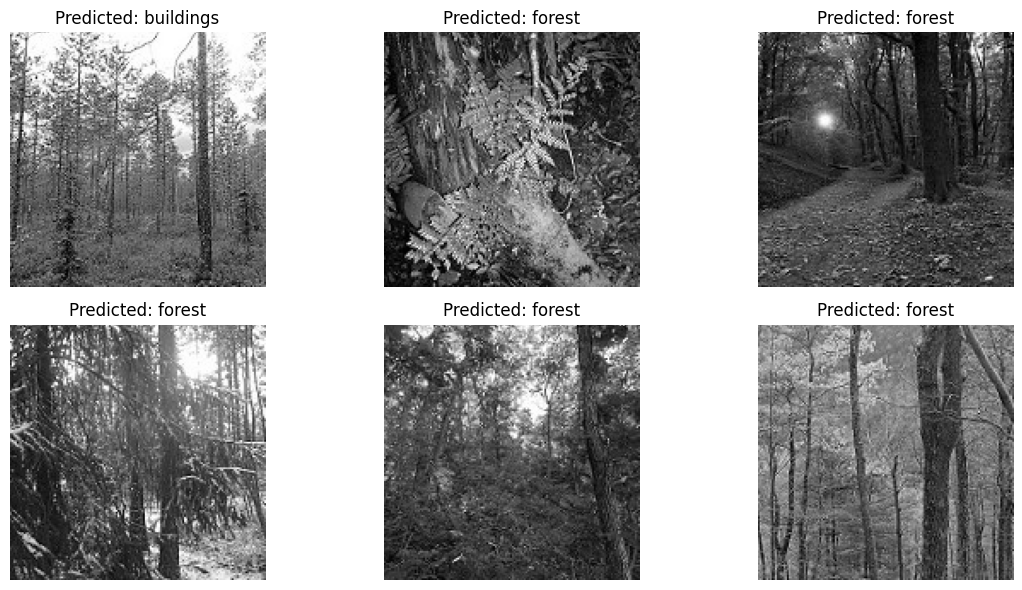

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# Load dataset
BASE_PATH = "intel_images/seg_train/"
BASE_PATH2 = "intel_images/seg_test/"
TRAIN_BUILDINGS_PATH = os.path.join(BASE_PATH, "buildings")
TRAIN_FOREST_PATH = os.path.join(BASE_PATH, "forest")
TEST_BUILDINGS_PATH = os.path.join(BASE_PATH2, "buildings")
TEST_FOREST_PATH = os.path.join(BASE_PATH2, "forest")

categories = ["forest", "buildings"]
image_paths = []
true_labels = []

# Load train images
for idx, category in enumerate(categories):
    folder = os.path.join(BASE_PATH, f"seg_train/{category}")
    for img_file in os.listdir(folder)[:100]:  # Limit to 100 images per category
        if img_file.endswith(('.jpg', '.png')):
            image_paths.append(os.path.join(folder, img_file))
            true_labels.append(idx)

# Read training images
images = []
for img_path in image_paths:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to load image: {img_path}")
        continue
    images.append(img)
true_labels = np.array(true_labels[:len(images)])  # Adjust labels to match loaded images

# Load test images
test_image_paths = []
test_labels = []

for idx, category in enumerate(categories):
    folder = os.path.join(BASE_PATH2, f"seg_test/{category}")  # Test dataset path
    for img_file in os.listdir(folder)[:20]:  # Load some test images
        if img_file.endswith(('.jpg', '.png')):
            test_image_paths.append(os.path.join(folder, img_file))
            test_labels.append(idx)

# Read test images
test_images = []
for img_path in test_image_paths:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to load test image: {img_path}")
        continue
    test_images.append(img)

test_labels = np.array(test_labels[:len(test_images)])  # Match labels to loaded test images

# Feature detector setup
FEATURE_DETECTOR = 'SIFT'  # Choose 'SIFT', 'SURF', or 'ORB'

if FEATURE_DETECTOR == 'SIFT':
    detector = cv2.SIFT_create()
elif FEATURE_DETECTOR == 'SURF':
    if hasattr(cv2, 'xfeatures2d'):
        detector = cv2.xfeatures2d.SURF_create(400)
    else:
        raise ImportError("SURF is not available in your OpenCV version.")
elif FEATURE_DETECTOR == 'ORB':
    detector = cv2.ORB_create()
else:
    raise ValueError(f"Unknown feature detector: {FEATURE_DETECTOR}")

def extract_features(image):
    """Extract features using the selected feature detector."""
    if image is None or image.size == 0:
        return np.zeros(128), []  # Return dummy features

    resized_img = cv2.resize(image, (64, 128), interpolation=cv2.INTER_AREA)
    keypoints, descriptors = detector.detectAndCompute(resized_img, None)

    if descriptors is None or len(descriptors) == 0:
        descriptors = np.zeros((1, 128))  # Handle empty descriptors

    feature_vector = np.mean(descriptors, axis=0)  # Compute mean feature vector
    return feature_vector, keypoints

# Extract features from training images
feature_list = []
for img in images:
    features, _ = extract_features(img)
    feature_list.append(features)
feature_matrix = np.array(feature_list)

# Standardize features
scaler = StandardScaler()
feature_matrix_scaled = scaler.fit_transform(feature_matrix)

# K-means clustering
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(feature_matrix_scaled)

# Train Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(feature_matrix_scaled, true_labels)

# Predict on test images
predictions = []
for test_img in test_images:
    test_features, keypoints = extract_features(test_img)
    test_features_scaled = scaler.transform([test_features])
    predicted_label = rfc.predict(test_features_scaled)[0]
    predictions.append(predicted_label)

# Display a few results
plt.figure(figsize=(12, 6))

for i in range(6):  # Show 6 test images with predictions
    test_img = test_images[i]
    pred_label = categories[predictions[i]]

    output_image = cv2.cvtColor(test_img, cv2.COLOR_GRAY2BGR)
    keypoints = cv2.drawKeypoints(test_img, [], output_image, (0, 255, 0),
                                  flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.subplot(2, 3, i + 1)
    plt.imshow(keypoints)
    plt.title(f"Predicted: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


Feature matrix shape: (200, 128)


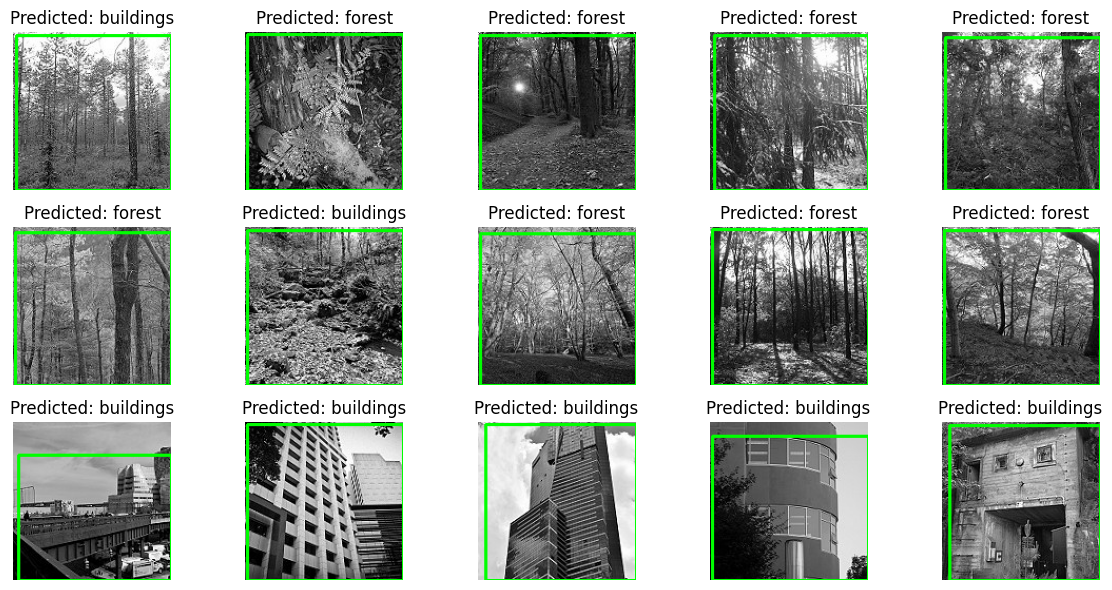

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# Load dataset
BASE_PATH = "intel_images/seg_train/"
BASE_PATH2 = "intel_images/seg_test/"
TRAIN_BUILDINGS_PATH = os.path.join(BASE_PATH, "buildings")
TRAIN_FOREST_PATH = os.path.join(BASE_PATH, "forest")
TEST_BUILDINGS_PATH = os.path.join(BASE_PATH2, "buildings")
TEST_FOREST_PATH = os.path.join(BASE_PATH2, "forest")

categories = ["forest", "buildings"]
image_paths = []
true_labels = []

# Load train images
for idx, category in enumerate(categories):
    folder = os.path.join(BASE_PATH, f"seg_train/{category}")
    for img_file in os.listdir(folder)[:100]:  # Limit to 100 images per category
        if img_file.endswith(('.jpg', '.png')):
            image_paths.append(os.path.join(folder, img_file))
            true_labels.append(idx)

# Read training images
images = []
for img_path in image_paths:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to load image: {img_path}")
        continue
    images.append(img)
true_labels = np.array(true_labels[:len(images)])  # Adjust labels to match loaded images

# Load test images (from both categories)
test_image_paths = []
test_labels = []

for idx, category in enumerate(categories):
    folder = os.path.join(BASE_PATH2, f"seg_test/{category}")  # Test dataset path
    for img_file in os.listdir(folder)[:10]:  # Load 10 from each category
        if img_file.endswith(('.jpg', '.png')):
            test_image_paths.append(os.path.join(folder, img_file))
            test_labels.append(idx)

# Read test images
test_images = []
for img_path in test_image_paths:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to load test image: {img_path}")
        continue
    test_images.append(img)

test_labels = np.array(test_labels[:len(test_images)])  # Match labels to loaded test images

# Read test images
test_images = []
for img_path in test_image_paths:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to load test image: {img_path}")
        continue
    test_images.append(img)

test_labels = np.array(test_labels[:len(test_images)])  # Match labels to loaded test images

# Feature detector setup
FEATURE_DETECTOR = 'SIFT'  # Choose 'SIFT', 'SURF', or 'ORB'

if FEATURE_DETECTOR == 'SIFT':
    detector = cv2.SIFT_create()
    descriptor_size = 128  # SIFT uses 128 features
elif FEATURE_DETECTOR == 'SURF':
    if hasattr(cv2, 'xfeatures2d'):
        detector = cv2.xfeatures2d.SURF_create(400)
        descriptor_size = 64  # SURF uses 64 features
    else:
        raise ImportError("SURF is not available in your OpenCV version.")
elif FEATURE_DETECTOR == 'ORB':
    detector = cv2.ORB_create()
    descriptor_size = 32  # ORB uses 32 features
else:
    raise ValueError(f"Unknown feature detector: {FEATURE_DETECTOR}")

def extract_features(image):
    """Extract features using the selected feature detector."""
    if image is None or image.size == 0:
        return np.zeros(descriptor_size)  # Return fixed-size zero vector

    resized_img = cv2.resize(image, (64, 128), interpolation=cv2.INTER_AREA)
    keypoints, descriptors = detector.detectAndCompute(resized_img, None)

    if descriptors is None or len(descriptors) == 0:
        return np.zeros(descriptor_size)  # Handle empty descriptors

    feature_vector = np.mean(descriptors, axis=0)  # Compute mean feature vector

    # Ensure consistent shape
    if feature_vector.shape[0] != descriptor_size:
        feature_vector = np.pad(feature_vector, (0, descriptor_size - feature_vector.shape[0]), mode='constant')

    return feature_vector

# Extract features from training images
feature_list = []
for img in images:
    features = extract_features(img)
    feature_list.append(features)

feature_matrix = np.array(feature_list)  # Ensure correct shape (N, descriptor_size)
print(f"Feature matrix shape: {feature_matrix.shape}")  # Debugging print

# Standardize features
scaler = StandardScaler()
feature_matrix_scaled = scaler.fit_transform(feature_matrix)

# K-means clustering
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(feature_matrix_scaled)

# Train Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(feature_matrix_scaled, true_labels)

# Predict on test images
predictions = []
bounding_boxes = []  # Store bounding box coordinates for each image

for test_img in test_images:
    test_features = extract_features(test_img)
    test_features_scaled = scaler.transform([test_features])
    predicted_label = rfc.predict(test_features_scaled)[0]
    predictions.append(predicted_label)

    # Detect keypoints for bounding box
    keypoints, _ = detector.detectAndCompute(test_img, None)

    if keypoints:
        x_coords = [int(kp.pt[0]) for kp in keypoints]
        y_coords = [int(kp.pt[1]) for kp in keypoints]
        x, y = min(x_coords), min(y_coords)
        w = max(x_coords) - x + 30  # Add padding
        h = max(y_coords) - y + 30  # Add padding
        # Ensure box stays within image bounds
        h, w = min(h, test_img.shape[0] - y), min(w, test_img.shape[1] - x)
    else:
        x, y, w, h = 20, 20, 80, 80  # Default box if no keypoints found

    bounding_boxes.append((x, y, w, h))

# Display results
plt.figure(figsize=(12, 6))

for i in range(min(len(test_images), 15)):  # Show up to 15 test images
    test_img = test_images[i]
    pred_label = categories[predictions[i]]

    output_image = cv2.cvtColor(test_img, cv2.COLOR_GRAY2BGR)
    keypoints_img = cv2.drawKeypoints(test_img, [], output_image, (0, 255, 0),
                                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Draw bounding box
    x, y, w, h = bounding_boxes[i]
    cv2.rectangle(keypoints_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.subplot(3, 5, i + 1)
    plt.imshow(cv2.cvtColor(keypoints_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()
